In [2]:


%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
# 설정값을 이렇게 설정도 한다

plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
# 캐글에서 많이 사용하는 라이브러리
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')




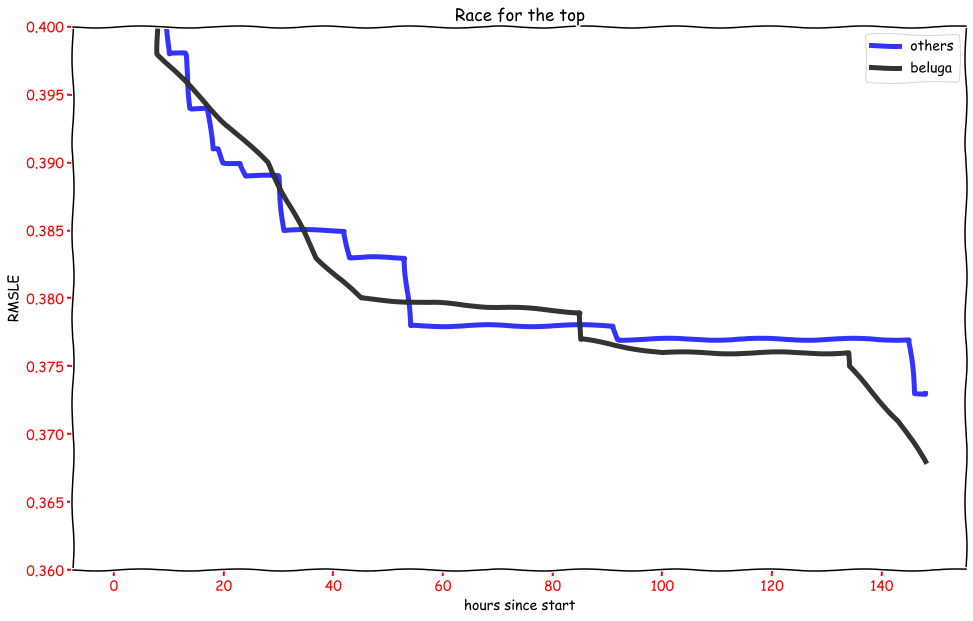

In [3]:

beluga = pd.DataFrame({'since_start_hour': [8.0, 8.0, 20.0, 28.0, 37.0, 45.0, 85.0, 85.0, 100.0, 134.0, 134.0, 143.0, 148.0],
                       'Score': [ 0.400,  0.398,  0.393,  0.390,  0.383,  0.380,  0.379,  0.377,  0.376,  0.376,  0.375,  0.371,  0.368]})
others = pd.DataFrame({'since_start_hour': [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,68,69,70,71,72,73,74,75,76,77,78,79,80,81,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148],
                        'BestScore': [.452,.452,.452,.452,.452,.452,.421,.421,.421,.406,.398,.398,.398,.398,.394,.394,.394,.394,.391,.391,.390,.390,.390,.390,.389,.389,.389,.389,.389,.389,.389,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.383,.383,.383,.383,.383,.383,.383,.383,.383,.383,.383,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.373,.373,.373]})

#
with plt.xkcd():
    # This figure will be in XKCD-style ?
    fig, ax = plt.subplots()
    # alpha : 투명도

    ax.plot(others.since_start_hour.values, others.BestScore.values, 'b', alpha=0.8, lw=5, label='others')
    ax.plot(beluga.since_start_hour.values, beluga.Score.values, 'k', alpha=0.8, lw=5, label='beluga')
    ax.set_ylim(0.36, 0.4)
    ax.legend(loc=0)
    ax.set_xlabel('hours since start')
    ax.set_ylabel('RMSLE')
    ax.set_title('Race for the top')

    ax.tick_params(direction='out' , length=6,width=2,colors='r')

    plt.show()

In [4]:
### Data understanding



In [5]:
np.random.seed(1989)
N = 100000  # number of sample rows in plots
t0 = dt.datetime.now()


train = pd.read_csv('C:\\Users\\tjdal\\PycharmProjects\\Kaggle\\newyorkcitytaxi\\train\\train.csv')
test = pd.read_csv('C:\\Users\\tjdal\\PycharmProjects\\Kaggle\\newyorkcitytaxi\\test\\test.csv')

In [6]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [7]:

train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


In [8]:
sample_submission = pd.read_csv('C:\\Users\\tjdal\\PycharmProjects\\Kaggle\\newyorkcitytaxi\\sample_submission\\sample_submission.csv')


In [10]:
print('we have {} train set'.format(len(train.shape[0])))
print('we have {} test set'.format(len(test.shape[0])))

TypeError: object of type 'int' has no len()

In [11]:
# nunique 유니크 개수
#
print('unique id : ' , train.id.nunique())

unique id :  1458644


In [12]:
import numpy as np

# intersect1d args1에 있지만 arg2에 없는 것
len(np.intersect1d(train.id.values, test.id.values))

0

In [13]:
# | 합집합이고 문자열로 뺐을 때 n만 y만 있다면 이상치 없다는 것 이런 행위를 왜 하는 지는
# 현업에서 겪어보면 축적되는 경험이다 생각해보니
print('The store_and_fwd_flag has only two values {}.'.format(str(set(train.store_and_fwd_flag.unique()) | set(test.store_and_fwd_flag.unique()))))

The store_and_fwd_flag has only two values {'N', 'Y'}.


In [14]:
test.dtypes


id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
dtype: object

In [15]:
train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [16]:
# type change

In [84]:
train['pickup_datetime'] =pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] =pd.to_datetime(test.pickup_datetime)



train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date

train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

In [18]:
# Y is 1 N is 0 trick


train['store_and_fwd_flag']= 1 * (train.store_and_fwd_flag == 'Y')
test['store_and_fwd_flag']= 1 * (train.store_and_fwd_flag == 'Y')

In [19]:
# real y check
# csv헤더컬럼이 1번 차지하고 인덱스는 0부터 시작하니 데이터프레임에서는 row -2가 될수있다.
train.iloc[348,:]

id                              id1633648
vendor_id                               1
pickup_datetime       2016-06-20 14:19:16
dropoff_datetime      2016-06-20 14:34:34
passenger_count                         1
pickup_longitude               -73.977905
pickup_latitude                 40.754871
dropoff_longitude              -73.952774
dropoff_latitude                40.768166
store_and_fwd_flag                      1
trip_duration                         918
pickup_date                    2016-06-20
Name: 348, dtype: object

In [20]:
# pickup_datetime type is datetime so on x(datetime).total_seconds method 사용 가능

# map은 series에 apply는 dataframe

train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
# preprocess는 왜 ? -> 모델에 넣기 좋게 피쳐 가공 필요 (사전에 모델 설계 필요하다는 뜻)


In [21]:
# 기존에 주어진 값과 비교 의심
# 시각화해서 탐색한다 의심점을 추상적 객체를 시각화해서

duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
#%
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


In [22]:


train['trip_duration'].max() // 3600

979

In [ ]:
##We can see that the max trip_duration is ~ 1000 hours.
# Fortunately the evaluation metric is RMSLE and not RMSE
# . Outliers will cause less trouble.
# We could logtransform our target label and use RMSE during training.
# ROOT 를 사용하기 때문에 아웃라이어의 trouble이 적어진다는 뜻

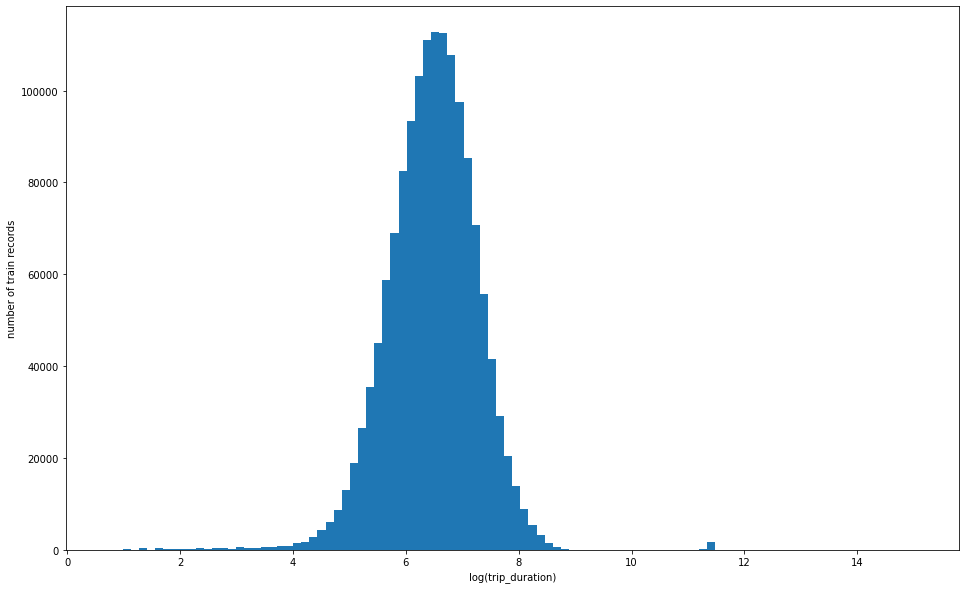

In [23]:
# 분포가 이쁘지 않고 outlier가 주는 영향이 너무 크기 때문에? log를 취해서 outlier 영향 줄이도록 이건 아니고 이미 평가지표가 rmse이기떄문
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
# plt.hist(train['trip_dupration'].values, bin =100) # 그래프가 보기 좋지 않음
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()


In [24]:
# 데이터프레임 boolean mask 씌윅
#mask = train.groupby('pickup_date').count() < 4000
#mask


In [25]:
train.dtypes()

TypeError: 'Series' object is not callable

In [26]:
train[train['pickup_date'] =='2016-01-01']

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,check_trip_duration,log_trip_duration


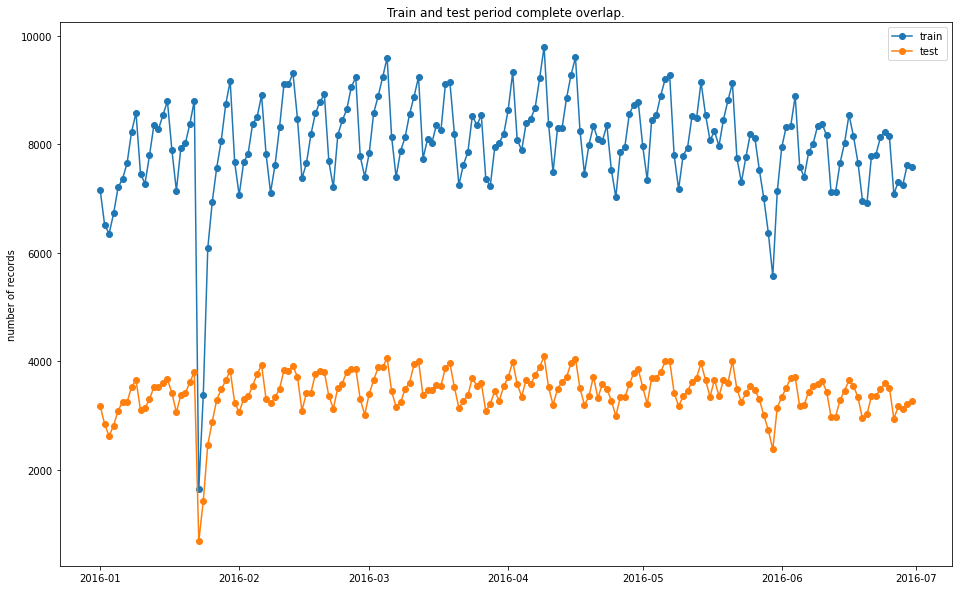

In [27]:

plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

In [28]:
# 특정 값 찾아보기
df = train.groupby('pickup_date').count()
# iloc 에 true false mask 는 넘겨 주지말고
# df.iloc[(df['id']<2000) ]
df.loc[(df['id']<2000) ]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,check_trip_duration,log_trip_duration
pickup_date,,,,,,,,,,,,,
2016-01-23,1648,1648,1648,1648,1648,1648,1648,1648,1648,1648,1648,1648,1648


In [29]:
#def foo1(x):
#    if x < 2000:
#       return x

#df = train.groupby('pickup_date').count()['id'].map(foo1)
#df
#lambda condition 단독 if 문 안되고 else 가 필요
df = train.groupby('pickup_date').count()['id'].apply(lambda x: x if x< 2000 else False)

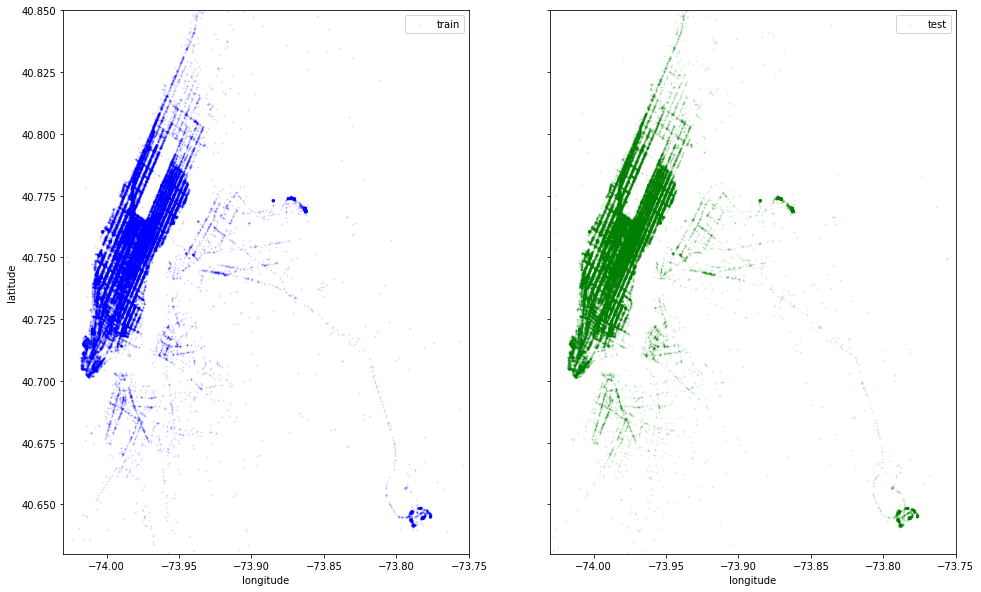

In [30]:
# 실제 뉴욕 경위도 찾기
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# share , sharey 축을 공유


fix , ax = plt.subplots(ncols=2, sharex=True , sharey =True)

# s는 marker size
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N] , color = 'blue' , s=1, label='train' ,alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:N], test['pickup_latitude'].values[:N],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()
# 갑자기 택시 줄어든 이유 ? -> 폭설을 생각

In [31]:
## Feature Extraction
# 아래로 쌓는다 like concat axis = 0
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

In [32]:
train[['pickup_latitude', 'pickup_longitude']].values

array([[ 40.76793671, -73.98215485],
       [ 40.73856354, -73.98041534],
       [ 40.7639389 , -73.97902679],
       ...,
       [ 40.76879883, -73.95912933],
       [ 40.74906158, -73.98207855],
       [ 40.78174973, -73.97953796]])

In [33]:
coords

array([[ 40.76793671, -73.98215485],
       [ 40.73856354, -73.98041534],
       [ 40.7639389 , -73.97902679],
       ...,
       [ 40.74866486, -73.87660217],
       [ 40.89178848, -73.85426331],
       [ 40.76937866, -73.96932983]])

In [34]:
test[['dropoff_latitude', 'dropoff_longitude']]

,dropoff_latitude,dropoff_longitude
0,40.756680,-73.990173
1,40.655403,-73.959808
2,40.729523,-73.986160
3,40.730469,-73.986427
4,40.755890,-73.961510
...,...,...
625129,40.733643,-74.001251
625130,40.782467,-73.953407
625131,40.748665,-73.876602
625132,40.891788,-73.854263


In [35]:
### fit and transform
# https://builtin.com/data-science/step-step-explanation-principal-component-analysis pca 이해
# PCA쓸 생각은 어떻게? -> 데이터가 다차원의 데이터니까 1차원으로 PCA 분석을 할 생각을 할 수 있다
pca = PCA().fit(coords)
# 여기서는 dimension reduction 이 아니라 transform 2D ->2D 로 한다 값을 줄이기 위함 아래의 plot에서

In [36]:
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

In [37]:
train['pickup_pca0']

0          0.007691
1          0.007677
2          0.004803
3          0.038342
4         -0.002877
             ...   
1458639    0.009052
1458640    0.027656
1458641   -0.015345
1458642    0.008722
1458643    0.004269
Name: pickup_pca0, Length: 1458644, dtype: float64

In [38]:
train[['pickup_latitude', 'pickup_longitude']]


,pickup_latitude,pickup_longitude
0,40.767937,-73.982155
1,40.738564,-73.980415
2,40.763939,-73.979027
3,40.719971,-74.010040
4,40.793209,-73.973053
...,...,...
1458639,40.745522,-73.982201
1458640,40.747379,-74.000946
1458641,40.768799,-73.959129
1458642,40.749062,-73.982079


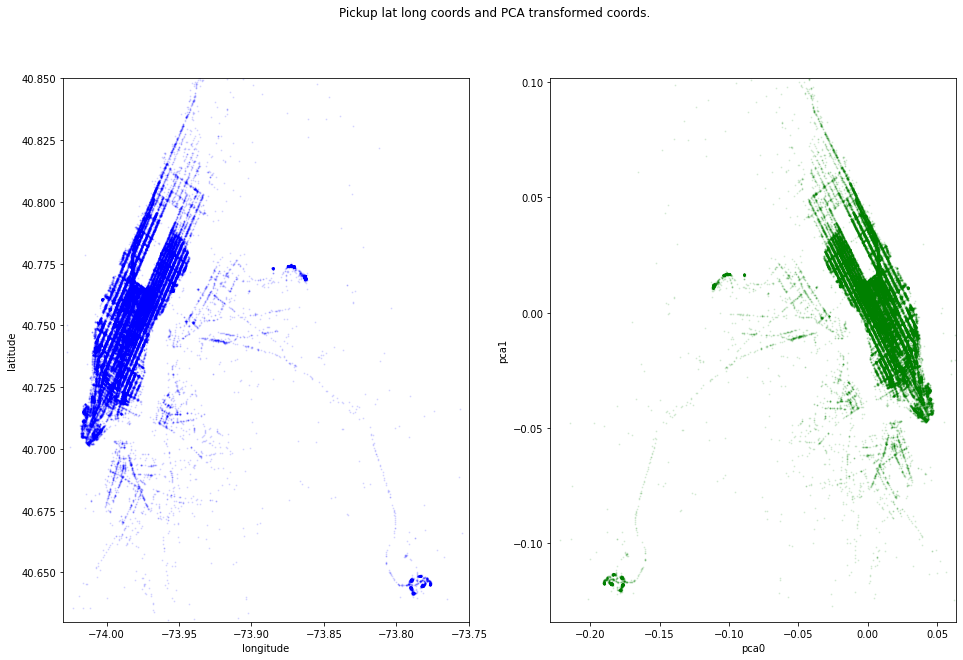

In [39]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N],
              color='green', s=1, alpha=0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

In [40]:
# https://www.google.com/search?q=harversine&oq=harversine&aqs=chrome..69i57j46i10j0i512j0i10i512j0i10j46i10j0i10l2j46i10.2640j0j4&sourceid=chrome&ie=UTF-8
"""""
Distance
Let's calculate the distance (km) between pickup and dropoff points.
Currently Haversine is used, geopy has another heuristics (vincenty() or great_circle()) if you prefer.
The cabs are not flying and we are in New York so we could check the Manhattan (L1) distance too :)
pd.DataFrame.apply() would be too slow so the haversine function is rewritten to handle arrays.
We extraxt the middle of the path as a feature as well.
"""""
# 거리는 왜 구하지? -> 우선 택시 승차지점과 하차지점을 구하는 건데

# '구'의 거리를 구한다
# haversine 공식 구현
# https://en.wikipedia.org/wiki/Haversine_formula#Formulation
# 데이터에 따라 방법을 적용하는 것이고 상황에 따라 집중하면 된다
#  위도나 경도는 지구 중심을 기반으로 하는 각도이기때문에 라디안으로 변환가능 <ㅡ 이런 걸 찾는다 답답한 것
def haversine_array(lat1, lng1, lat2, lng2):
    # radian은 호도법에 의한 각도의 단위

    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km earth 구의 반경
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [41]:
# 맨해튼  거리는 유클리드 거리처럼 건물 블럭들이 있다고 했을 때 건물을 뚫고 지나갈 수 없다고 가정한 L1 distance로 불린다#
# taxi이므로 맨해튼거리
# 여기서 dummy 는 ? 이 단어도 그냥 안 넘어 간다 하나하나를 (운동도 공부도 이렇게 해야한다^^)
# 실제로 두 점 사이에서 가로질러가는 게아니라면 왼쪽 방향도 있고 오른 쪽 방향도 있으므로 둘 다 구하는 식
#
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    # 좌표의 구성을 잘 보고 ppt로 시각화 해보면 안다
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b
#


### www.movable-type.co.uk/scripts/latlong.html
# bearing(방향) harversine등의 거리 구하는 방법 모두 있다
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [42]:

train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values,
                                                     train['pickup_longitude'].values,
                                                     train['dropoff_latitude'].values,
                                                     train['dropoff_longitude'].values
                                                     )

In [43]:
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(
    train['pickup_latitude'].values
    ,train['pickup_longitude'].values
    ,train['dropoff_latitude'].values,
     train['dropoff_longitude'].values
)

In [44]:
test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

In [45]:
train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

In [46]:
## Datetime features
# 무슨 일주일 중 요일인 지 구한다
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:,'pickup_weekday']

0          0
1          6
2          1
3          2
4          5
          ..
1458639    4
1458640    6
1458641    4
1458642    1
1458643    1
Name: pickup_weekday, Length: 1458644, dtype: int64

In [47]:
# datetime을 1년 중의 몇 번째 주로 바꿀 수 있다 good 인데?
train.loc[:, 'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'pickup_hour_weekofyear']

0          11
1          23
2           3
3          14
4          12
           ..
1458639    14
1458640     1
1458641    16
1458642     1
1458643    14
Name: pickup_hour_weekofyear, Length: 1458644, dtype: int64

In [48]:
# 24시간 중 몇 시 인지 구한다
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour

In [49]:
train.loc[:, 'pickup_datetime']

0         2016-03-14 17:24:55
1         2016-06-12 00:43:35
2         2016-01-19 11:35:24
3         2016-04-06 19:32:31
4         2016-03-26 13:30:55
                  ...        
1458639   2016-04-08 13:31:04
1458640   2016-01-10 07:35:15
1458641   2016-04-22 06:57:41
1458642   2016-01-05 15:56:26
1458643   2016-04-05 14:44:25
Name: pickup_datetime, Length: 1458644, dtype: datetime64[ns]

In [50]:
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
# 가장 최소값인 pickupdate와 비교를 해서 초 단위로 구한다
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()

In [51]:
#

# 한주에서 몇번째 날 어느 시간에 탔는 지 .
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']
train.loc[:, 'pickup_week_hour']

0           17
1          144
2           35
3           67
4          133
          ... 
1458639    109
1458640    151
1458641    102
1458642     39
1458643     38
Name: pickup_week_hour, Length: 1458644, dtype: int64

In [52]:
test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']


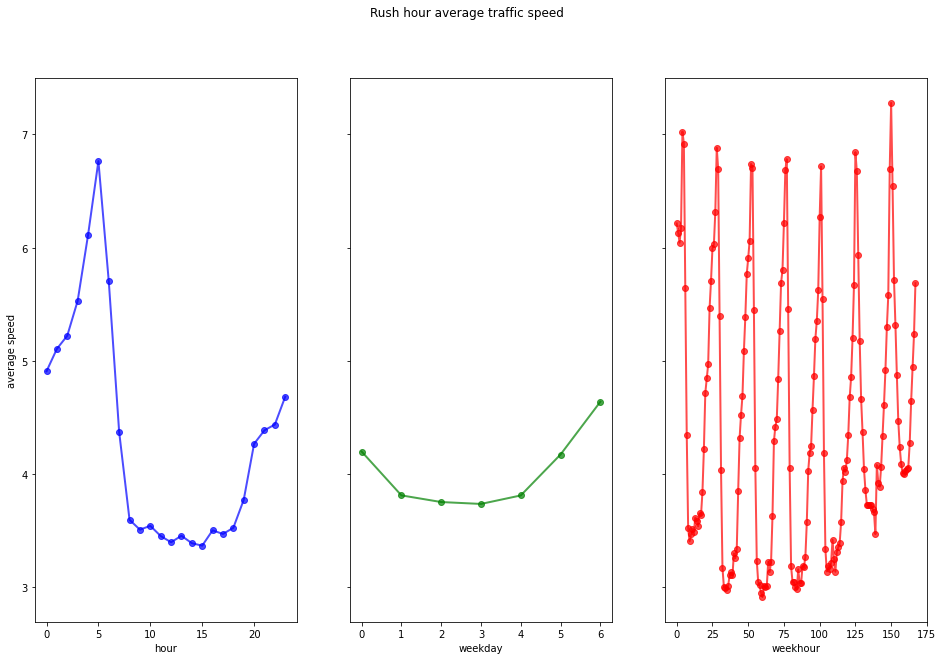

In [53]:
# 속력 = 거리/ 시간
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']


fig, ax = plt.subplots(ncols=3, sharey=True)
# 시간별 , 요일별 , 요일시간별 평균 속력 값 -> 이건 왜 했지?
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()


# 실제로 해결하려면 실제 문제라고 정의를 잘 해야 한다
# 단편적인 지식을 나열하지 말고
# step1 목표를 세우고
# step2 그에 맞는 구조를 세우고 나서
# step3 그에 따른 논리 과정을 펼쳐야 한다
# 스스로 먼저
# ex)사용자가 어떤 원하는 목표가 있어서 데이터 카탈로그를 찾는 데 목표와 연관된 데이터 카탈로그를 찾기 힘들다-> 데이터 카탈로그 추천시스템 목적
# -> 따라서 collaborative filtering 이 가장 잘 적용될 추천시스템이라고 판단
# 그러니 사용자가 데이터를 찾아가는 과정이 중요할 거 같고 time_stamp 별로 무엇을 찾는 지 학습 필요
# -> 이전 time-step 에 어떤 아이템을 찾았고 다음 time-step에 추천해 줄 아이템들이 뭐가 있는지 ,
# 목표가 어느 것인지 특정하기 위해
# Kprototype도 그런 비슷한 목표를 위해 아이템을 구매한 이력을 모은 cluster 로 모으는 거니까
#  그래서 실시간 추천 시스템 mab는 또 반드시 넣어야 겠다
# 장기적으로 또 구매패턴을 학습하는 DNN도 활용할 수 있을 듯 하고d
# 그런 cluster 를 어떻게 더 잘 형성하는 지에 대해 연구하고 잘 적용하면 되겠다
# dnn은 구매이력을 잘 조정 해야 할 듯 한데 방향은 잘 모르겠다
# https://www.kaggle.com/ruslankl/how-to-deal-with-multi-armed-bandit-problem

In [74]:
# round 3번째 자리까지 있으면 3번째 까지로 반올림 하라 이런 것이 feature enginiring
# 6번째 자리까지 있으므로
train.loc[:,'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:,'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions

In [65]:
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))
test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

In [73]:
# 경도와 위도를 group하여 시속의 평균을 구한다
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()

In [56]:
coord_speed

,pickup_lat_bin,pickup_long_bin,avg_speed_h
0,34.360,-65.848,0.000000
1,34.712,-75.354,359.730518
2,35.082,-71.800,1458.615554
3,35.310,-72.074,50.225452
4,36.029,-77.441,0.000000
...,...,...,...
13019,43.140,-72.591,0.000000
13020,43.487,-74.195,0.000000
13021,43.912,-71.882,0.000000
13022,44.372,-66.972,190.297588


In [57]:
coord_count

,pickup_lat_bin,pickup_long_bin,id
0,34.360,-65.848,1
1,34.712,-75.354,1
2,35.082,-71.800,1
3,35.310,-72.074,1
4,36.029,-77.441,1
...,...,...,...
13019,43.140,-72.591,1
13020,43.487,-74.195,1
13021,43.912,-71.882,1
13022,44.372,-66.972,1


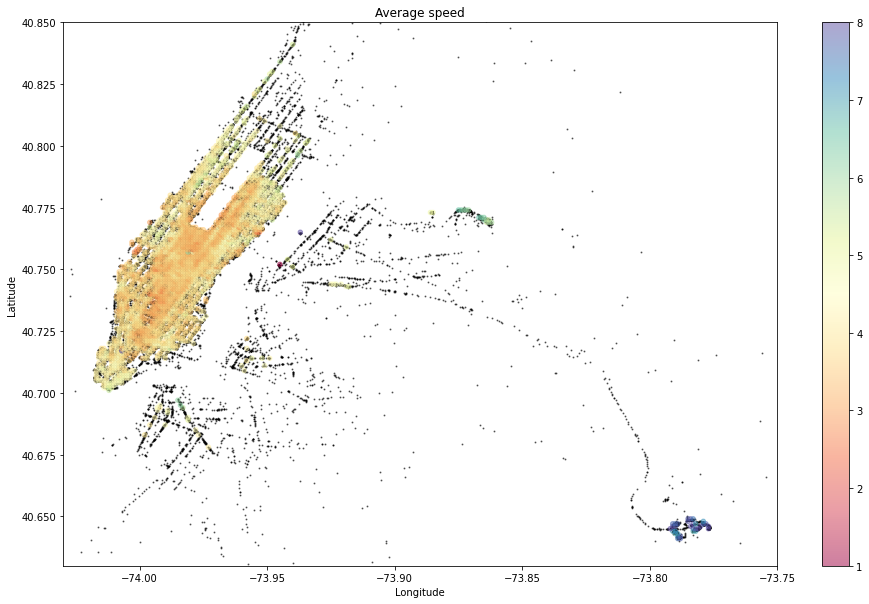

In [58]:
# 위도와 경도에 따른 속력의 분포
#  를 어떻게 표현하는가 ? 코드로 . 이런 것을 본다 말은 쉽고 보는 건 쉽다
# merge하면 그룹키가 있는 것들로만 merge 되고 컬럼은 붙는다 l_key 하나 하나에 data double
# leftouter join 은 1:1 과 N:1 관계일때만 행 수가 그대로이고 1:N 이면 1개의 컬럼에 n개가 다  붙기 때문에 데이터가 뻥튀기된다
# inner join 이 merge의 기본 값 이므로 여기서는 뻥튀기 되지 않는다
# on은 left right의 key 이름이 같을 경우 사용
coord_stats = pd.merge(coord_speed , coord_count , on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1,nrows=1)
plot1 = ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N] , color='black', s=1 , alpha=0.5) # alpha는 투명도 s는
plot2 = ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values,
           c=coord_stats.avg_speed_h.values,
           cmap='Spectral', s=20, alpha=0.5, vmin=1, vmax=8)
# c 는 컬러보여줄 array-like list value
# s는 하나한의 점 크기지정
# vmin vmax는 colorbar의 수치 설정
# yuhan studycode
fig.colorbar(plot2,ax=ax )

# xlim ylim 설정을 통해 확대 축소 할수 있다
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.title('Average speed')
plt.show()

# cmap 은 RdYlGn 색깔?
# Subclasses of matplotlib.cm.ScalarMappable make heavy use of this data -> normalize -> map-to-color processing chain.print
# cmap 은 data normalize 후 mat to color 하는 옵션 매핑 되는 map 을 정한다
# https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html 숫자의 대소 컬러표현
# cmaps['Diverging'] = [
#            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
#            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

In [59]:
coords
# 길이 만큼의 sample index 를 투입해서 train 시켜야 연속된 값으로 인한 잘못된 traing을 방지한다

array([[ 40.76793671, -73.98215485],
       [ 40.73856354, -73.98041534],
       [ 40.7639389 , -73.97902679],
       ...,
       [ 40.74866486, -73.87660217],
       [ 40.89178848, -73.85426331],
       [ 40.76937866, -73.96932983]])

In [60]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

# kmeans 알고리즘을 통해 특정 위도경도의 클러스터를 예측하는데

In [61]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])
t1 = dt.datetime.now()
print('Time till clustering: %i seconds' % (t1 - t0).seconds)

Time till clustering: 173 seconds


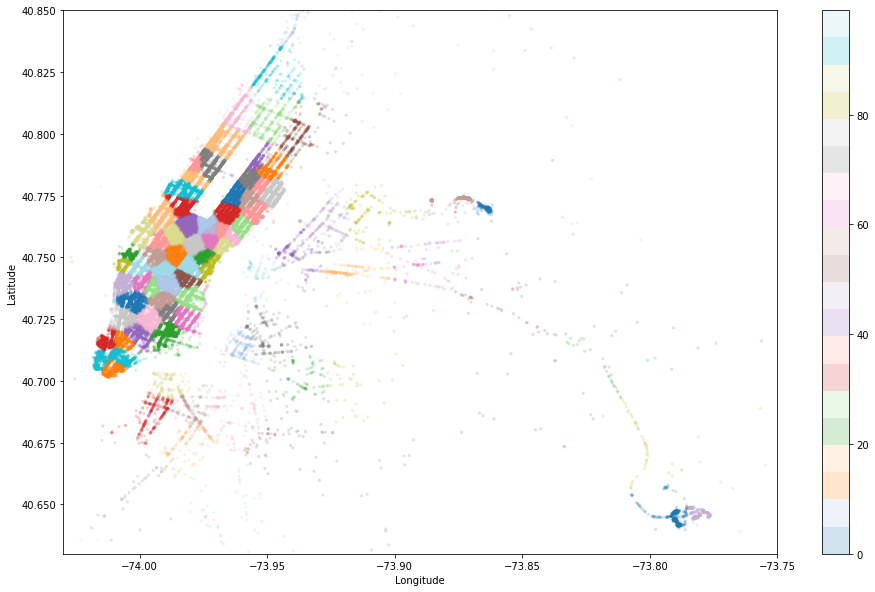

In [62]:
#  cluster 가 너무 다양한것아닌가 클러스터 넣을 때 피쳐를 잘 설정해서 trainning 잘 하기

fig, ax = plt.subplots(ncols=1, nrows=1)
plot3 = ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
plt.colorbar(plot3,ax=ax )
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [63]:
"""
시간 집계와 공간 집계
Temporal and geospatial aggregation
Add a few average traffic speed features. Note that if the train/test split would be time based then we could not use as much temporal features. In this competition we do not need to predict the future.
"""

'\nTemporal and geospatial aggregation\nAdd a few average traffic speed features. Note that if the train/test split would be time based then we could not use as much temporal features. In this competition we do not need to predict the future.\n'

In [66]:
for gby_col in ['pickup_hour', 'pickup_date', 'pickup_dt_bin',
               'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 'log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]

    # right_index 는 조인 키로 사용한 오른쪽 데이터프레임의 인덱스를 가져온다
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)

In [ ]:
train.groupby(gby_col).mean()

In [90]:
for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)


In [96]:
# 위경도별 평균시속을 붙인다 trainning 하기위해
train['avg_speed_h_center_lat_bin_center_long_bin']

0          3.537861
1          3.537631
2          3.412069
3          2.664721
4          4.985574
             ...   
1458639    3.412069
1458640    4.129244
1458641    4.130243
1458642    3.225561
1458643    4.673674
Name: avg_speed_h_center_lat_bin_center_long_bin, Length: 1458644, dtype: float64

In [ ]:
train.loc[gby_cols]

In [94]:
coord_stats

,pickup_cluster,dropoff_cluster,avg_speed_h_pickup_cluster_dropoff_cluster,cnt_pickup_cluster_dropoff_cluster
0,0,0,2.262499,1381
2,0,2,4.448429,151
5,0,5,4.571299,359
6,0,6,3.788369,279
7,0,7,3.342505,671
...,...,...,...,...
8834,99,92,3.162779,272
8837,99,95,2.784687,258
8838,99,96,3.096119,106
8839,99,97,2.499753,760


In [ ]:
train.loc[:,'pickup_long_bin']

In [80]:
train.loc[['pick_up_long_bin']]


KeyError: "None of [Index(['pick_up_long_bin'], dtype='object')] are in the [index]"

In [86]:
df_all = pd.concat((train,test))[['id', 'pickup_datetime','pickup_cluster','dropoff_cluster']]

In [87]:
df_all

,id,pickup_datetime,pickup_cluster,dropoff_cluster
0,id2875421,2016-03-14 17:24:55,31,33
1,id2377394,2016-06-12 00:43:35,51,0
2,id3858529,2016-01-19 11:35:24,40,91
3,id3504673,2016-04-06 19:32:31,32,12
4,id2181028,2016-03-26 13:30:55,72,72
...,...,...,...,...
625129,id3008929,2016-01-01 00:02:52,76,0
625130,id3700764,2016-01-01 00:01:52,46,74
625131,id2568735,2016-01-01 00:01:24,48,62
625132,id1384355,2016-01-01 00:00:28,29,1


In [109]:
train.loc[:, 'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)

In [100]:
train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,cnt_center_lat_bin_center_long_bin,avg_speed_h_pickup_hour_center_lat_bin_center_long_bin,cnt_pickup_hour_center_lat_bin_center_long_bin,avg_speed_h_pickup_hour_pickup_cluster,cnt_pickup_hour_pickup_cluster,avg_speed_h_pickup_hour_dropoff_cluster,cnt_pickup_hour_dropoff_cluster,avg_speed_h_pickup_cluster_dropoff_cluster,cnt_pickup_cluster_dropoff_cluster,pickup_datetime_group
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,57030.0,3.085869,3451.0,3.125139,1997.0,3.152616,1828.0,3.094555,1145.0,2016-03-14 17:00:00
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,53601.0,3.553433,2701.0,4.460090,1033.0,3.816875,1328.0,3.023479,634.0,2016-06-12 01:00:00
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,82646.0,2.933729,3795.0,3.002281,2212.0,3.749163,643.0,4.266995,259.0,2016-01-19 12:00:00
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,...,9309.0,2.971749,558.0,4.369693,1123.0,4.640253,520.0,2.782026,652.0,2016-04-06 20:00:00
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,...,19077.0,4.312554,990.0,3.908849,1361.0,3.903739,1300.0,2.960742,1304.0,2016-03-26 14:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,0,...,82646.0,2.893499,3941.0,3.257729,1638.0,3.188234,800.0,3.461788,399.0,2016-04-08 14:00:00
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,0,...,15063.0,4.579404,499.0,4.119676,489.0,4.617860,667.0,NaN,NaN,2016-01-10 08:00:00
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,0,...,46822.0,6.271895,1094.0,5.486751,844.0,6.497910,301.0,7.770331,215.0,2016-04-22 07:00:00
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,0,...,91065.0,2.767088,4377.0,3.159748,1412.0,3.009248,1285.0,3.658283,1256.0,2016-01-05 16:00:00


In [110]:
group_freq='60min'
# Count trips over 60min
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()

In [166]:
df_counts.isnull().rolling(group_freq).count()

,id
pickup_datetime,
2016-01-01 00:00:17,1.0
2016-01-01 00:00:22,2.0
2016-01-01 00:00:28,3.0
2016-01-01 00:00:53,4.0
2016-01-01 00:01:01,5.0
...,...
2016-06-30 23:59:39,624.0
2016-06-30 23:59:41,625.0
2016-06-30 23:59:47,625.0


,id,count_60min
pickup_datetime,,
2016-01-01 00:00:17,1.0,1.0
2016-01-01 00:00:22,2.0,2.0
2016-01-01 00:00:28,3.0,3.0
2016-01-01 00:00:53,4.0,4.0
2016-01-01 00:01:01,5.0,5.0
...,...,...
2016-06-30 23:59:39,624.0,624.0
2016-06-30 23:59:41,625.0,625.0
2016-06-30 23:59:47,625.0,625.0


In [112]:
# 시간 60min 단위로 rolling이 가능
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']

,id,count_60min
pickup_datetime,,
2016-01-01 00:00:17,id0190469,1.0
2016-01-01 00:00:22,id0621643,2.0
2016-01-01 00:00:28,id1384355,3.0
2016-01-01 00:00:53,id1665586,4.0
2016-01-01 00:01:01,id1210365,5.0
...,...,...
2016-06-30 23:59:39,id3719493,624.0
2016-06-30 23:59:41,id2150126,625.0
2016-06-30 23:59:47,id1217141,625.0


In [152]:
# rolling에 시간이 적용 가능
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()

In [165]:
#df_counts.isnull().rolling(group_freq)

Rolling [window=60min,min_periods=1,center=False,win_type=freq,axis=0,method=single]

,id
pickup_datetime,


In [182]:
df_counts
# rolling에 시간이 적용되고 index가 datetime like이면 가변적으로 rolling이적용된다
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']

In [178]:
# If its an offset then this will be the time period of each window. Each window will be a variable sized based on the observations included in the time-period. This is only valid for datetimelike indexes.
#df_counts.isnull().rolling(group_freq)

Rolling [window=60min,min_periods=1,center=False,win_type=freq,axis=0,method=single]

In [187]:
#df_counts[3:20]

,id,count_60min
pickup_datetime,,
2016-01-01 00:00:53,id1665586,4.0
2016-01-01 00:01:01,id1210365,5.0
2016-01-01 00:01:14,id3888279,6.0
2016-01-01 00:01:20,id0924227,6.0
2016-01-01 00:01:24,id2568735,6.0
2016-01-01 00:01:33,id2294362,6.0
2016-01-01 00:01:37,id1078247,7.0
2016-01-01 00:01:47,id3609443,8.0
2016-01-01 00:01:52,id3700764,9.0
